# Solución Prueba Técnica MercadoLibre

importando dependencias y datos

In [1]:
import json
import pandas as pd

In [2]:
# You can safely assume that `build_dataset` is correctly implemented
def build_dataset():
    data = [json.loads(x) for x in open("MLA_100k_checked_v3.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = build_dataset()

# Feature engineering

Since the original data has a considerable amount of nested fields, we start evaluating what features can be extracted from those nested fields. Attempting to convert the list of dictionaries to dataframe preserving as much information as possible (since nested fields can't easily parsed to dataframe)

Dado que los JSON originales tienen una cantidad considerable de campos anidados, comenzamos evaluando qué características se pueden extraer de esos campos anidados. Todo con la intención de `aplanar` (`flatten`) los JSON, y así poder convertirlos más facilmente a DataFrame

## Evaluando campos anidados

### evaluando el campo `pictures`

Este campo parece mostrar información de las imágenes asociadas a los productos, de aquí se puede extraer información como la resolución de las imágenes y la cantidad de imágenes. Valores que pueden aportar a la decisión de clasificar un producto como nuevo o usado. a continuación se detalla el paso a paso de la creación de características:

- Se visualiza la estructura de la información dentro del campo:

In [3]:
X_train[36478].get('pictures', [])

[{'size': '500x402',
  'secure_url': 'https://a248.e.akamai.net/mla-s1-p.mlstatic.com/4502-MLA9433684496_012013-O.jpg',
  'max_size': '530x427',
  'url': 'http://mla-s1-p.mlstatic.com/4502-MLA9433684496_012013-O.jpg',
  'quality': '',
  'id': '4502-MLA9433684496_012013'},
 {'size': '500x401',
  'secure_url': 'https://a248.e.akamai.net/mla-s1-p.mlstatic.com/4585-MLA9433684496_012013-O.jpg',
  'max_size': '530x426',
  'url': 'http://mla-s1-p.mlstatic.com/4585-MLA9433684496_012013-O.jpg',
  'quality': '',
  'id': '4585-MLA9433684496_012013'},
 {'size': '500x310',
  'secure_url': 'https://a248.e.akamai.net/mla-s2-p.mlstatic.com/4526-MLA9433684496_012013-O.jpg',
  'max_size': '600x372',
  'url': 'http://mla-s2-p.mlstatic.com/4526-MLA9433684496_012013-O.jpg',
  'quality': '',
  'id': '4526-MLA9433684496_012013'},
 {'size': '500x457',
  'secure_url': 'https://a248.e.akamai.net/mla-s1-p.mlstatic.com/4554-MLA9433684496_012013-O.jpg',
  'max_size': '600x549',
  'url': 'http://mla-s1-p.mlstatic.c

- Llama la atención el campo `quality` dado que puede ofrecer información relevante pero parece estar vacío, evaluemos si viene vacío para todos los productos:

In [4]:
# List to store all quality values
quality_values = []

# Iterate through each dictionary in the list
for item in X_train + X_test:
    # Extract the 'pictures' list
    pictures = item.get('pictures', [])
    # Extract the 'quality' value from each picture and add it to the quality_values list
    for picture in pictures:
        quality_values.append(picture.get('quality', ''))

# Print the unique quality values
set(quality_values)

{''}

El resultado de valores únicos en `quality` demuestra que este campo siempre viene vacío.

Ahora procedemos a extraer las `features` de la resolución y la cantidad de imágenes para los productos:

**`features` extraídas del campo `pictures`:**

1. **Número de Imágenes**:
   - `num_pictures`: El número total de imágenes disponibles para el artículo.

2. **Resoluciones Únicas de Imágenes**:
   - `unique_picture_resolutions`: El número de resoluciones únicas entre las imágenes.

3. **Resolución Promedio de Imágenes**:
   - `avg_picture_resolution`: La resolución promedio (ancho * alto) de las imágenes.

4. **Resolución Máxima de Imágenes**:
   - `max_picture_resolution`: La resolución más alta entre las imágenes.

5. **Resolución Mínima de Imágenes**:
   - `min_picture_resolution`: La resolución más baja entre las imágenes.

6. **Relación de Aspecto Promedio**:
   - `avg_picture_aspect_ratio`: La relación de aspecto promedio (ancho/alto) de las imágenes.

7. **Relación de Aspecto Máxima**:
   - `max_picture_aspect_ratio`: La relación de aspecto más alta entre las imágenes.

8. **Relación de Aspecto Mínima**:
   - `min_picture_aspect_ratio`: La relación de aspecto más baja entre las imágenes.

9. **Consistencia en las Resoluciones de Imágenes**:
    - `picture_resolution_std_dev`: La desviación estándar de las resoluciones de las imágenes para medir la consistencia.


se crea entonces una función que extrae estas características del campo `pictures` para cada `JSON` dentro de los datos, adicionalmente esta función elimina el campo `pictures` después de haber extraído las variables.

In [5]:
import numpy as np

def extract_picture_features(item):
    """
    Extract relevant features from the 'pictures' field of a dictionary.

    Args:
    item (dict): A dictionary representing an item with a 'pictures' field.

    Returns:
    dict: A dictionary containing extracted picture features.
    """
    pictures = item.get('pictures', [])
    
    num_pictures = len(pictures)
    resolutions = [tuple(map(int, pic['size'].split('x'))) for pic in pictures]
    unique_resolutions = len(set(resolutions))
    
    if num_pictures > 0:
        avg_picture_resolution = np.mean([w * h for w, h in resolutions])
        max_picture_resolution = max([w * h for w, h in resolutions])
        min_picture_resolution = min([w * h for w, h in resolutions])
        
        avg_aspect_ratio = np.mean([w / h for w, h in resolutions])
        max_aspect_ratio = max([w / h for w, h in resolutions])
        min_aspect_ratio = min([w / h for w, h in resolutions])
        
        resolution_std_dev = np.std([w * h for w, h in resolutions])
        
    else:
        avg_picture_resolution = max_picture_resolution = min_picture_resolution = 0
        avg_aspect_ratio = max_aspect_ratio = min_aspect_ratio = 0
        resolution_std_dev = 0
    
    features = {
        'num_pictures': num_pictures,
        'unique_picture_resolutions': unique_resolutions,
        'avg_picture_resolution': avg_picture_resolution,
        'max_picture_resolution': max_picture_resolution,
        'min_picture_resolution': min_picture_resolution,
        'avg_picture_aspect_ratio': avg_aspect_ratio,
        'max_picture_aspect_ratio': max_aspect_ratio,
        'min_picture_aspect_ratio': min_aspect_ratio,
        'picture_resolution_std_dev': resolution_std_dev
    }
    
    return features

def process_items_picture_features(item_list):
    """
    Process a list of dictionaries to extract picture features and remove the original 'pictures' key from each dictionary.

    Args:
    item_list (list): A list of dictionaries, each representing an item with a 'pictures' field.

    Returns:
    list: A list of processed item dictionaries with extracted picture features and without the 'pictures' key.
    """
    processed_items = []
    
    for item in item_list:
        # Extract picture features
        picture_features = extract_picture_features(item)
        
        # Remove the original 'pictures' key
        item.pop('pictures', None)
        
        # Add the new features to the item dictionary
        item.update(picture_features)
        
        # Append the processed item to the list
        processed_items.append(item)
    
# Applying the function
process_items_picture_features(X_test)
process_items_picture_features(X_train)

### evaluando el campo `variations`

Para ver qué tan relevante es este campo nos preguntamos

Qué porcentaje de artículos tiene variaciones?

en train:

In [6]:
def calculate_variations_percentage(items):
    total_items = len(items)
    items_with_variations = sum(1 for item in items if 'variations' in item and item['variations'])
    
    percentage_with_variations = (items_with_variations / total_items) * 100 if total_items else 0
    
    return items_with_variations, percentage_with_variations

items_with_variations, percentage_with_variations = calculate_variations_percentage(X_train)
print(f"Total items with variations in train partition: {items_with_variations}")
print(f"Percentage of items with variations: {percentage_with_variations:.2f}%")

Total items with variations in train partition: 7374
Percentage of items with variations: 8.19%


en test:

In [7]:
def calculate_variations_percentage(items):
    total_items = len(items)
    items_with_variations = sum(1 for item in items if 'variations' in item and item['variations'])
    
    percentage_with_variations = (items_with_variations / total_items) * 100 if total_items else 0
    
    return items_with_variations, percentage_with_variations

items_with_variations, percentage_with_variations = calculate_variations_percentage(X_test)
print(f"Total items with variations in test partition: {items_with_variations}")
print(f"Percentage of items with variations: {percentage_with_variations:.2f}%")

Total items with variations in test partition: 818
Percentage of items with variations: 8.18%


8% es un numero relevante de articulos, ahora revisamos el contenido del campo para ver qué se puede extraer de ahí

In [8]:
X_train[29]['variations']

[{'attribute_combinations': [{'value_id': '92013',
    'name': 'Color Primario',
    'value_name': 'Azul',
    'id': '83000'},
   {'value_id': '101995', 'name': 'Talle', 'value_name': 'M', 'id': '93000'}],
  'seller_custom_field': None,
  'picture_ids': ['21897-MLA20219050871_122014',
   '21826-MLA20219051350_122014',
   '21894-MLA20219051403_122014',
   '21871-MLA20219051434_122014',
   '17709-MLA20142698862_082014'],
  'sold_quantity': 1,
  'available_quantity': 2,
  'id': 9391988875,
  'price': 590},
 {'attribute_combinations': [{'value_id': '92013',
    'name': 'Color Primario',
    'value_name': 'Azul',
    'id': '83000'},
   {'value_id': '101994', 'name': 'Talle', 'value_name': 'S', 'id': '93000'}],
  'seller_custom_field': None,
  'picture_ids': ['21897-MLA20219050871_122014',
   '21826-MLA20219051350_122014',
   '21894-MLA20219051403_122014',
   '21871-MLA20219051434_122014',
   '17709-MLA20142698862_082014'],
  'sold_quantity': 0,
  'available_quantity': 2,
  'id': 9391988878,

veamos cuáles son los valores de `attribute_combinations` que puede tener un artículo (valores únicos)

In [9]:
def collect_attribute_combination_names(items):
    attribute_combination_names = []

    for item in items:
        if 'variations' in item and item['variations']:
            for variation in item['variations']:
                if 'attribute_combinations' in variation and variation['attribute_combinations']:
                    for attribute in variation['attribute_combinations']:
                        if 'name' in attribute:
                            attribute_combination_names.append(attribute['name'])

    return attribute_combination_names

attribute_combination_names = collect_attribute_combination_names(X_train)

set(attribute_combination_names)

{'Color Primario', 'Color Secundario', 'Talle'}

dado que un artículo dentro de `attribute_combinations` solo puede tener 'Color Primario', 'Color Secundario' o 'Talle', se extrae el conteo de distintos colores o tallas que pueden tener las variaciones de un artículo

una hipótesis inicial puede ser que si un artículo tiene tantos detalles en sus variaciones, es muy probable que sea nuevo. Pero se deja para confirmación en el análisis exploratorio.

**`features` extraídas del campo `variations`:**

1. **Número Total de Variaciones**:
   - `variations_count`: Cantidad de todas las variaciones del producto.

2. **Estadísticas de Precios de Variaciones**:
   - `variation_price_mean`: Precio promedio de todas las variaciones.
   - `variation_price_std`: Desviación estándar de los precios de todas las variaciones.
   - `variation_price_max`: Precio máximo entre todas las variaciones.
   - `variation_price_min`: Precio mínimo entre todas las variaciones.

3. **Estadísticas de Cantidad Vendida**:
   - `variation_total_sold_quantity`: Cantidad total vendida en todas las variaciones.
   - `variation_sold_quantity_mean`: Cantidad promedio vendida en todas las variaciones.
   - `variation_sold_quantity_std`: Desviación estándar de las cantidades vendidas en todas las variaciones.
   - `variation_sold_quantity_max`: Cantidad máxima vendida entre todas las variaciones.
   - `variation_sold_quantity_min`: Cantidad mínima vendida entre todas las variaciones.

4. **Estadísticas de Cantidad Disponible**:
   - `variation_total_available_quantity`: Cantidad total disponible en todas las variaciones.
   - `variation_available_quantity_mean`: Cantidad promedio disponible en todas las variaciones.
   - `variation_available_quantity_std`: Desviación estándar de las cantidades disponibles en todas las variaciones.
   - `variation_available_quantity_max`: Cantidad máxima disponible entre todas las variaciones.
   - `variation_available_quantity_min`: Cantidad mínima disponible entre todas las variaciones.

5. **Información de Imágenes**:
   - `variations_with_pictures_count`: Cantidad de variaciones que tienen imágenes asociadas.
   - `avg_pictures_per_variation`: Número promedio de imágenes por variación.
   - `max_pictures_per_variation`: Número máximo de imágenes en cualquier variación.
   - `min_pictures_per_variation`: Número mínimo de imágenes en cualquier variación.

6. **Attribute Combinations**:
   - `variations_distinct_primary_colors`: Cantidad de colores primarios distintos en las variaciones.
   - `variations_distinct_secondary_colors`: Cantidad de colores secundarios distintos en las variaciones.
   - `variations_distinct_sizes`: Cantidad de tamaños distintos (o 'Talle') en las variaciones.

7. **Presencia de Campo `seller_custom_field`**:
   - `variations_have_seller_custom_field`: Booleano (1 o 0) que indica si alguna variación tiene el campo `seller_custom_field`.

Ahora se crea una `función` para extraer estas `features`, y posteriormente eliminar el campo de `variations`. Logrando así avanzar en el objetivo de `aplanar` el `JSON`

In [10]:
def extract_variation_features(product):
    """
    Extracts various features from the 'variations' field of a product dictionary.

    Args:
    product (dict): A dictionary representing a product.

    Returns:
    dict: A dictionary containing extracted variation features.
    """
    variations = product.get('variations', [])
    
    # Initialize statistics
    prices = []
    sold_quantities = []
    available_quantities = []
    num_pictures = []
    color_primary = set()
    color_secondary = set()
    sizes = set()
    has_seller_custom_field = 0
    
    for variation in variations:
        prices.append(variation.get('price', 0))
        sold_quantities.append(variation.get('sold_quantity', 0))
        available_quantities.append(variation.get('available_quantity', 0))
        num_pictures.append(len(variation.get('picture_ids', [])))
        
        if variation.get('seller_custom_field'):
            has_seller_custom_field = 1
        
        for attribute in variation.get('attribute_combinations', []):
            name = attribute.get('name')
            value_name = attribute.get('value_name')
            
            if name == 'Color Primario':
                color_primary.add(value_name)
            elif name == 'Color Secundario':
                color_secondary.add(value_name)
            elif name == 'Talle':
                sizes.add(value_name)

    # Calculate statistics
    num_variations = len(variations)
    variation_price_mean = sum(prices) / num_variations if num_variations else 0
    variation_price_std = (sum((x - variation_price_mean) ** 2 for x in prices) / num_variations) ** 0.5 if num_variations else 0
    variation_price_max = max(prices, default=0)
    variation_price_min = min(prices, default=0)
    
    total_sold_quantity = sum(sold_quantities)
    sold_quantity_mean = sum(sold_quantities) / num_variations if num_variations else 0
    sold_quantity_std = (sum((x - sold_quantity_mean) ** 2 for x in sold_quantities) / num_variations) ** 0.5 if num_variations else 0
    sold_quantity_max = max(sold_quantities, default=0)
    sold_quantity_min = min(sold_quantities, default=0)
    
    total_available_quantity = sum(available_quantities)
    available_quantity_mean = sum(available_quantities) / num_variations if num_variations else 0
    available_quantity_std = (sum((x - available_quantity_mean) ** 2 for x in available_quantities) / num_variations) ** 0.5 if num_variations else 0
    available_quantity_max = max(available_quantities, default=0)
    available_quantity_min = min(available_quantities, default=0)
    
    num_variations_with_pictures = sum(1 for x in num_pictures if x > 0)
    avg_pictures_per_variation = sum(num_pictures) / num_variations if num_variations else 0
    max_pictures_per_variation = max(num_pictures, default=0)
    min_pictures_per_variation = min(num_pictures, default=0)
    
    distinct_primary_colors = len(color_primary)
    distinct_secondary_colors = len(color_secondary)
    distinct_sizes = len(sizes)
    
    # Compile features
    features = {
        'variations_count': num_variations,
        'variation_price_mean': variation_price_mean,
        'variation_price_std': variation_price_std,
        'variation_price_max': variation_price_max,
        'variation_price_min': variation_price_min,
        'variation_total_sold_quantity': total_sold_quantity,
        'variation_sold_quantity_mean': sold_quantity_mean,
        'variation_sold_quantity_std': sold_quantity_std,
        'variation_sold_quantity_max': sold_quantity_max,
        'variation_sold_quantity_min': sold_quantity_min,
        'variation_total_available_quantity': total_available_quantity,
        'variation_available_quantity_mean': available_quantity_mean,
        'variation_available_quantity_std': available_quantity_std,
        'variation_available_quantity_max': available_quantity_max,
        'variation_available_quantity_min': available_quantity_min,
        'variations_with_pictures_count': num_variations_with_pictures,
        'avg_pictures_per_variation': avg_pictures_per_variation,
        'max_pictures_per_variation': max_pictures_per_variation,
        'min_pictures_per_variation': min_pictures_per_variation,
        'variations_distinct_primary_colors': distinct_primary_colors,
        'variations_distinct_secondary_colors': distinct_secondary_colors,
        'variations_distinct_sizes': distinct_sizes,
        'variations_have_seller_custom_field': has_seller_custom_field
    }
    
    return features

def process_items_variation_features(item_list):
    """
    Process a list of dictionaries to extract variation features and remove the original 'variations' key from each dictionary.

    Args:
    item_list (list): A list of dictionaries, each representing an item with a 'pictures' field.

    Returns:
    list: A list of processed item dictionaries with extracted variation features and without the 'variations' key.
    """
    processed_items = []
    
    for item in item_list:
        # Extract variation features
        variation_features = extract_variation_features(item)
        
        # Remove the original 'pictures' key
        item.pop('variations', None)
        
        # Add the new features to the item dictionary
        item.update(variation_features)
        
        # Append the processed item to the list
        processed_items.append(item)

# Applying the function
process_items_variation_features(X_train)
process_items_variation_features(X_test)

### evaluando el campo `attributes`

Para ver qué tan relevante es este campo nos preguntamos

Qué porcentaje de artículos tiene `attributes`?

en train:

In [11]:
def calculate_attributes_percentage(items):
    total_items = len(items)
    items_with_attributes = sum(1 for item in items if 'attributes' in item and item['attributes'])
    
    percentage_with_attributes = (items_with_attributes / total_items) * 100 if total_items else 0
    
    return items_with_attributes, percentage_with_attributes

items_with_attributes, percentage_with_attributes = calculate_attributes_percentage(X_train)
print(f"Total items with attributes in train partition: {items_with_attributes}")
print(f"Percentage of items with attributes: {percentage_with_attributes:.2f}%")

Total items with attributes in train partition: 11150
Percentage of items with attributes: 12.39%


en test:

In [12]:
def calculate_attributes_percentage(items):
    total_items = len(items)
    items_with_attributes = sum(1 for item in items if 'attributes' in item and item['attributes'])
    
    percentage_with_attributes = (items_with_attributes / total_items) * 100 if total_items else 0
    
    return items_with_attributes, percentage_with_attributes

items_with_attributes, percentage_with_attributes = calculate_attributes_percentage(X_test)
print(f"Total items with attributes in test partition: {items_with_attributes}")
print(f"Percentage of items with attributes: {percentage_with_attributes:.2f}%")

Total items with attributes in test partition: 1275
Percentage of items with attributes: 12.75%


ahora se visualiza el contenido de `attributes` para entender la estructura:

In [13]:
X_train[30198]['attributes']

[{'value_id': '',
  'attribute_group_id': 'ADICIONALES',
  'name': 'Expensas ($)',
  'value_name': '2500',
  'attribute_group_name': 'Adicionales',
  'id': 'MLA1472-EXPENCEM'},
 {'value_id': 'MLA1459-INMUEBLE-DEPARTAMENTO',
  'attribute_group_id': 'FIND',
  'name': 'Inmueble',
  'value_name': 'Departamento',
  'attribute_group_name': 'Ficha técnica',
  'id': 'MLA1459-INMUEBLE'},
 {'value_id': 'MLA1459-OPERACION-ALQUILER',
  'attribute_group_id': 'FIND',
  'name': 'Operación',
  'value_name': 'Alquiler',
  'attribute_group_name': 'Ficha técnica',
  'id': 'MLA1459-OPERACION'},
 {'value_id': 'MLA1472-AMBQTY-3',
  'attribute_group_id': 'FIND',
  'name': 'Ambientes',
  'value_name': '3',
  'attribute_group_name': 'Ficha técnica',
  'id': 'MLA1472-AMBQTY'},
 {'value_id': 'MLA1472-ANTIG-HASTA_5_ANOS',
  'attribute_group_id': 'FIND',
  'name': 'Antigüedad',
  'value_name': 'Hasta 5 años',
  'attribute_group_name': 'Ficha técnica',
  'id': 'MLA1472-ANTIG'},
 {'value_id': 'MLA1472-BATHQTY-1',
  

Hay tres campos que llaman la atención, estos son `attribute_group_id`, `name`, `value_name`, `attribute_group_name`. Se les presta mucha atención a estos campos dado que puede que nos den un indicio de la `categoría` del artículo. Y basado en la experiencia, la `categoría` del producto es una variable muy útil al momento de hacer modelos de clasificación.

empecemos con el campo `attribute_group_id`, veamos cuales son los distintos valores que se pueden extraer de este campo:

In [14]:
def get_distinct_attribute_group_ids(dict_list):
    attribute_group_ids = set()
    vowel_map = str.maketrans('ÁÉÍÓÚáéíóú', 'AEIOUaeiou')

    for d in dict_list:
        if 'attributes' in d:
            for attribute in d['attributes']:
                if 'attribute_group_id' in attribute:
                    transformed_attribute = attribute['attribute_group_id'].upper().translate(vowel_map)
                    attribute_group_ids.add(transformed_attribute)
                    
    return attribute_group_ids

attribute_group_ids_set = get_distinct_attribute_group_ids(X_train)

attribute_group_ids_set

{'ADICIONALES',
 'AMBIENTES',
 'CARACTERISTICAS',
 'COMODIDADES',
 'COMOYAMEN',
 'CONFORT',
 'DDPLANAHO',
 'DFLT',
 'EQUIPAMIENTO',
 'EXTERIOR',
 'FIND',
 'RANGCUOTA',
 'SECURITY',
 'SONIDO'}

ahora los distintos valores para `name`

In [15]:
def get_distinct_attribute_names(dict_list):
    attribute_names = set()
    vowel_map = str.maketrans('ÁÉÍÓÚáéíóú', 'AEIOUaeiou')
    
    for d in dict_list:
        if 'attributes' in d:
            for attribute in d['attributes']:
                if 'name' in attribute:
                    transformed_name = attribute['name'].upper().translate(vowel_map)
                    attribute_names.add(transformed_name)
                    
    return attribute_names

get_distinct_attribute_names(X_train)

{'% DE SEÑA',
 'A CUANTAS CUADRAS DEL CENTRO',
 'A CUANTAS CUADRAS DEL MAR',
 'ACCESO',
 'ADECUADO PARA EVENTOS',
 'ADJUDICADO',
 'AGUA CORRIENTE',
 'AIRBAG CONDUCTOR',
 'AIRBAG DE CORTINA',
 'AIRBAG LATERALES',
 'AIRBAG PASAJERO',
 'AIRE ACONDICIONADO',
 'ALARMA',
 'ALARMA DE LUCES ENCENDIDAS',
 'ALARMA DE SEGURIDAD',
 'ALTO (MTS)',
 'ALTURA',
 'ALTURA DEL TECHO (M)',
 'AM/FM',
 'AMBIENTES',
 'AMBIENTES DEL CASCO',
 'AMOBLADO',
 'ANCHO',
 'ANCHO (MTS)',
 'ANTIGÜEDAD',
 'ANTIGÜEDAD DEL CASCO',
 'APERTURA REMOTA DE BAUL',
 'APOYA CABEZA EN ASIENTOS TRASEROS',
 'APTO PARA FAMILIAS/NIÑOS',
 'APTO PARA FUMADORES',
 'APTO PROFESIONAL',
 'ASCENSOR',
 'ASCENSOR DE SERVICIO',
 'ASIENTO ACOMPAÑANTE REGULABLE EN ALTURA',
 'ASIENTO CONDUCTOR REGULABLE EN ALTURA',
 'ASIENTO TRASERO REBATIBLE',
 'ASIENTOS ELECTRICOS',
 'AÑO',
 'BALCON',
 'BAR',
 'BAULERA',
 'BAULERA/ALTILLO',
 'BAÑOS',
 'BEBEDEROS',
 'BIBLIOTECA',
 'BLINDADO',
 'BLUETOOTH',
 'BUTACA CONDUCTOR ELECTRICA',
 'BUTACAS DELANTERAS TERMIC

ahora los distintos valores para `value_name`

In [16]:
def get_distinct_attribute_group_ids(dict_list):
    attribute_group_ids = set()
    vowel_map = str.maketrans('ÁÉÍÓÚáéíóú', 'AEIOUaeiou')
    for d in dict_list:
        if 'attributes' in d:
            for attribute in d['attributes']:
                if 'value_name' in attribute:
                    transformed_id = attribute['value_name'].upper().translate(vowel_map)
                    attribute_group_ids.add(transformed_id)

    return attribute_group_ids

get_distinct_attribute_group_ids(X_train)

{'',
 '111111',
 'MAM075',
 'NAFTA',
 'BIZ 125',
 'PS04010C',
 'DE 9 A 20',
 'R15/205/50',
 'MC2554',
 '358000',
 '15:00',
 '9 A 19 ',
 '300000',
 'VKMA 01000',
 'CR018',
 '9 A 13/14:30 A 18:30',
 '111',
 'CLASSIC 1.9 TDI HIGHLINE ABS AB TC',
 'R 12',
 'D211',
 'PS59610I',
 '1336Z0',
 '1.6 FLY VIRAL (L/08)',
 '31 DE ENERO 2016',
 'ROUSER 200 NS',
 'R20/OTRASMEDIDAS/OTRASMEDIDAS',
 '94007MI_A',
 'WAGON WIND 1.6 N',
 '225/45 R17',
 'CORVEN HUNTER 200',
 '10-23HS',
 '38253MX',
 'RL DIESEL 5PTAS.',
 'CUSTON',
 'RM8654',
 'R16/195/60',
 'SANDERO STEPWAY',
 '597091',
 '1.0 AA CD 3PTAS.',
 '44413MI',
 '55000',
 'MI28KD',
 '93315492',
 '47557',
 '27360',
 '2005',
 '70000',
 '39',
 'SL 125',
 '9 A 19:30 HS',
 '7702217591',
 '8:00 A 19:30 HS',
 'VTH5615',
 '374332',
 '930 A 19',
 '1/02/2015',
 'PLATA',
 '4PTAS. 1.6 N GLS (L08)',
 'R14/195/70',
 'FASE 2 - 5PTAS. 1.6 EXPRESSION',
 'AG251053',
 'EN 125 2A',
 'ASFALTO',
 '34875G',
 'R18/235/40',
 '10800',
 '1.8T FSI (160CV) MULTITRONIC SPORT ALCANTA

`value_name` aporta información muy específica de cada artículo, no de las `categorías` de los artículos

ahora los distintos valores para `attribute_group_name`

In [17]:
def get_distinct_attribute_group_ids(dict_list):
    attribute_group_ids = set()
    vowel_map = str.maketrans('ÁÉÍÓÚáéíóú', 'AEIOUaeiou')
    for d in dict_list:
        if 'attributes' in d:
            for attribute in d['attributes']:
                if 'attribute_group_name' in attribute:
                    transformed_id = attribute['attribute_group_name'].upper().translate(vowel_map)
                    attribute_group_ids.add(transformed_id)

    return attribute_group_ids

get_distinct_attribute_group_ids(X_train)

{'',
 'ADICIONALES',
 'AMBIENTES',
 'CARACTERISTICAS ADICIONALES',
 'COMODIDADES',
 'COMODIDADES Y AMENITIES',
 'CONFORT',
 'DETALLES DEL PLAN DE AHORRO',
 'EQUIPAMIENTO',
 'EXTERIOR',
 'FICHA TECNICA',
 'OTROS',
 'RANGO DE CUOTAS',
 'SEGURIDAD',
 'SONIDO'}

ahora que conocemos los distintos valores de estos campos, sabemos que sí aportan información sobre la `categoría` del artículo. Ahora se necesita saber si hay o no una jerarquía entre estos campos, con el fin de determinar cuál de ellos se va a usar como una variable en el modelo de clasificación.

evaluemos si hay jerarquía entre `attribute_group_id` y `attribute_group_name`:

In [18]:
def get_attribute_group_pairs(dict_list):
    attribute_group_pairs = set()
    vowel_map = str.maketrans('ÁÉÍÓÚáéíóú', 'AEIOUaeiou')
    
    for d in dict_list:
        if 'attributes' in d:
            for attribute in d['attributes']:
                if 'attribute_group_id' in attribute and 'attribute_group_name' in attribute:
                    transformed_id = attribute['attribute_group_id'].upper().translate(vowel_map)
                    transformed_name = attribute['attribute_group_name'].upper().translate(vowel_map)
                    pair = (transformed_id, transformed_name)
                    attribute_group_pairs.add(pair)
                    
    return attribute_group_pairs

get_attribute_group_pairs(X_train)

{('ADICIONALES', 'ADICIONALES'),
 ('ADICIONALES', 'COMODIDADES'),
 ('ADICIONALES', 'FICHA TECNICA'),
 ('AMBIENTES', 'AMBIENTES'),
 ('CARACTERISTICAS', ''),
 ('CARACTERISTICAS', 'CARACTERISTICAS ADICIONALES'),
 ('COMODIDADES', 'COMODIDADES'),
 ('COMODIDADES', 'COMODIDADES Y AMENITIES'),
 ('COMOYAMEN', 'COMODIDADES Y AMENITIES'),
 ('CONFORT', 'CONFORT'),
 ('DDPLANAHO', 'DETALLES DEL PLAN DE AHORRO'),
 ('DFLT', 'OTROS'),
 ('EQUIPAMIENTO', 'EQUIPAMIENTO'),
 ('EXTERIOR', 'EXTERIOR'),
 ('FIND', 'FICHA TECNICA'),
 ('RANGCUOTA', 'RANGO DE CUOTAS'),
 ('SECURITY', 'SEGURIDAD'),
 ('SONIDO', 'SONIDO')}

ambos campos parecen tener un nivel de jerarquía equivalente, en esta ocasión, nos quedamos con el campo de `attribute_group_id` dado que está más estandarizado que el resto. El campo `name` podría representar una sub categoría del `attribute_group_id` y podría ser usado para futuros experimentos y comprobar si agregar esta información mejora las métricas de clasificación.

In [19]:
attribute_group_ids_list = list(attribute_group_ids_set) # list of possible attribute_group_id values

def extract_attributes_features(product):
    """
    Extracts various features from the 'attributes' field of a product dictionary.

    Args:
    product (dict): A dictionary representing a product.

    Returns:
    dict: A dictionary containing extracted attributes features.
    """
    attributes = product.get('attributes', [])
    for group_id in attribute_group_ids_list:
        product[f'has_attribute_group_id_{group_id}'] = any(attr['attribute_group_id'] == group_id for attr in attributes)

    # Ensure all attribute group id keys are present with False if 'attributes' field does not exist
    for group_id in attribute_group_ids_list:
        if f'has_attribute_group_id_{group_id}' not in product:
            product[f'has_attribute_group_id_{group_id}'] = False

    return product


def process_items_attributes_features(item_list):
    """
    Process a list of dictionaries to extract attributes features and remove the original 'attributes' key from each dictionary.

    Args:
    item_list (list): A list of dictionaries, each representing an item with an 'attributes' field.

    Returns:
    list: A list of processed item dictionaries with extracted attributes features and without the 'attributes' key.
    """
    processed_items = []
    
    for item in item_list:
        # Extract attributes features
        attributes_features = extract_attributes_features(item)
        
        # Remove the original 'pictures' key
        item.pop('attributes', None)
        
        # Add the new features to the item dictionary
        item.update(attributes_features)
        
        # Append the processed item to the list
        processed_items.append(item)
    
# Applying the function
process_items_attributes_features(X_test)
process_items_attributes_features(X_train)

### evaluando el campo `non_mercado_pago_payment_methods`

Este campo describe los métodos de pago aceptados por el seller, distintos de mercadopago.

Para ver qué tan relevante es este campo nos preguntamos

Qué porcentaje de artículos tiene `non_mercado_pago_payment_methods`?

In [20]:
def calculate_non_mercado_pago_payment_methods_percentage(items):
    total_items = len(items)
    items_with_non_mercado_pago_payment_methods = sum(1 for item in items if 'non_mercado_pago_payment_methods' in item and item['non_mercado_pago_payment_methods'])
    
    percentage_with_non_mercado_pago_payment_methods = (items_with_non_mercado_pago_payment_methods / total_items) * 100 if total_items else 0
    
    return items_with_non_mercado_pago_payment_methods, percentage_with_non_mercado_pago_payment_methods

items_with_non_mercado_pago_payment_methods, percentage_with_non_mercado_pago_payment_methods = calculate_non_mercado_pago_payment_methods_percentage(X_train)
print(f"Total items with non_mercado_pago_payment_methods in train partition: {items_with_non_mercado_pago_payment_methods}")
print(f"Percentage of items with non_mercado_pago_payment_methods: {percentage_with_non_mercado_pago_payment_methods:.2f}%")

Total items with non_mercado_pago_payment_methods in train partition: 62469
Percentage of items with non_mercado_pago_payment_methods: 69.41%


In [21]:
def calculate_non_mercado_pago_payment_methods_percentage(items):
    total_items = len(items)
    items_with_non_mercado_pago_payment_methods = sum(1 for item in items if 'non_mercado_pago_payment_methods' in item and item['non_mercado_pago_payment_methods'])
    
    percentage_with_non_mercado_pago_payment_methods = (items_with_non_mercado_pago_payment_methods / total_items) * 100 if total_items else 0
    
    return items_with_non_mercado_pago_payment_methods, percentage_with_non_mercado_pago_payment_methods

items_with_non_mercado_pago_payment_methods, percentage_with_non_mercado_pago_payment_methods = calculate_non_mercado_pago_payment_methods_percentage(X_test)
print(f"Total items with non_mercado_pago_payment_methods in test partition: {items_with_non_mercado_pago_payment_methods}")
print(f"Percentage of items with non_mercado_pago_payment_methods: {percentage_with_non_mercado_pago_payment_methods:.2f}%")

Total items with non_mercado_pago_payment_methods in test partition: 6972
Percentage of items with non_mercado_pago_payment_methods: 69.72%


69% es un numero super relevante de articulos, ahora revisamos el contenido del campo para ver qué se puede extraer de ahí

In [22]:
X_train[384]['non_mercado_pago_payment_methods']

[{'description': 'MasterCard', 'id': 'MLAMC', 'type': 'C'},
 {'description': 'Mastercard Maestro', 'id': 'MLAMS', 'type': 'D'},
 {'description': 'Cheque certificado', 'id': 'MLABC', 'type': 'G'},
 {'description': 'Visa Electron', 'id': 'MLAVE', 'type': 'D'},
 {'description': 'Transferencia bancaria', 'id': 'MLATB', 'type': 'G'},
 {'description': 'Visa', 'id': 'MLAVS', 'type': 'C'},
 {'description': 'Diners', 'id': 'MLADC', 'type': 'C'},
 {'description': 'Acordar con el comprador', 'id': 'MLAWC', 'type': 'G'},
 {'description': 'Giro postal', 'id': 'MLAWT', 'type': 'G'},
 {'description': 'Efectivo', 'id': 'MLAMO', 'type': 'G'},
 {'description': 'American Express', 'id': 'MLAAM', 'type': 'C'}]

Se evidencia que el nombre de método de pago está en el campo `description`, adicionalmente el campo `type` agrupa los métodos de pago por lo que parece ser `C` de crédito, `D` de débito, y `G` de todos los demás métodos de pago como efectivo o acuerdo con el comprador.

Considerando esto, nos vamos con el campo `description` dado a que aporta más información que `type`.

In [23]:
def get_distinct_non_mercado_pago_payment_methods(dict_list):
    pago_payment_methods = set()
    for d in dict_list:
        if 'non_mercado_pago_payment_methods' in d:
            for attribute in d['non_mercado_pago_payment_methods']:
                if 'description' in attribute:
                    pago_payment_methods.add(attribute['description'])

    return list(pago_payment_methods)

distinct_payment_methods = get_distinct_non_mercado_pago_payment_methods(X_train)

distinct_payment_methods

['Giro postal',
 'American Express',
 'Cheque certificado',
 'Visa Electron',
 'Mastercard Maestro',
 'Transferencia bancaria',
 'Diners',
 'Acordar con el comprador',
 'Tarjeta de crédito',
 'MasterCard',
 'Efectivo',
 'Contra reembolso',
 'MercadoPago',
 'Visa']

se crea entonces una funcion que diga o no si determinado artículo acepta o no alguno de estos métodos de pago:

In [24]:
def extract_payment_methods_features(product):
    """
    Extracts various features from the 'non_mercado_pago_payment_methods' field of a product dictionary.

    Args:
    product (dict): A dictionary representing a product.

    Returns:
    dict: A dictionary containing extracted non_mercado_pago_payment_methods features.
    """
    non_mercado_pago_payment_methods = product.get('non_mercado_pago_payment_methods', [])
    for payment_method in distinct_payment_methods:
        product[f'accepts_payment_method_{payment_method}'] = any(attr['description'] == payment_method for attr in non_mercado_pago_payment_methods)

    # Ensure all payment methods are present with False if 'non_mercado_pago_payment_methods' field does not exist
    for payment_method in distinct_payment_methods:
        if f'accepts_payment_method_{payment_method}' not in product:
            product[f'has_payment_method_{payment_method}'] = False

    return product

def process_payment_methods_features(item_list):
    """
    Process a list of dictionaries to extract payment methods features and remove the original 'non_mercado_pago_payment_methods' key from each dictionary.

    Args:
    item_list (list): A list of dictionaries, each representing an item with an 'non_mercado_pago_payment_methods' field.

    Returns:
    list: A list of processed item dictionaries with extracted payment methods features and without the 'non_mercado_pago_payment_methods' key.
    """
    processed_items = []
    
    for item in item_list:
        # Extract attributes features
        payment_method_features = extract_payment_methods_features(item)
        
        # Remove the original 'non_mercado_pago_payment_methods' key
        item.pop('non_mercado_pago_payment_methods', None)
        
        # Add the new features to the item dictionary
        item.update(payment_method_features)
        
        # Append the processed item to the list
        processed_items.append(item)
    
# Applying the function
process_payment_methods_features(X_test)
process_payment_methods_features(X_train)

### evaluando el campo `tags`

este campo tiene ciertos `tags` que parecen aportar información interesante, primero veamos qué distintos `tags` puede tener un artículo:

In [25]:
def get_distinct_tags(dict_list):
    tags = set()
    for d in dict_list:
        if 'tags' in d:
            for tag in d['tags']:
                tags.add(tag)

    return list(tags)

tags_list = get_distinct_tags(X_train)

tags_list

['free_relist',
 'dragged_bids_and_visits',
 'good_quality_thumbnail',
 'poor_quality_thumbnail',
 'dragged_visits']

y ahora se revisa qué porcentaje de artículos tienen estos `tags`

In [26]:
def calculate_tags_percentage(items):
    total_items = len(items)
    items_with_tags = sum(1 for item in items if 'tags' in item and item['tags'])
    
    percentage_with_tags = (items_with_tags / total_items) * 100 if total_items else 0
    
    return items_with_tags, percentage_with_tags

items_with_tags, percentage_with_tags = calculate_tags_percentage(X_train)
print(f"Total items with tags in train partition: {items_with_tags}")
print(f"Percentage of items with tags: {percentage_with_tags:.2f}%")

Total items with tags in train partition: 67588
Percentage of items with tags: 75.10%


dado que 75% de los items tienen `tags`, esto cobra especial relevancia. se extraen ahora las caracteristicas de los tags. esta variable toma los distintos valores que puede tener un `tag`, e indica si un artículo tiene o no ese `tag`

In [27]:
def extract_tags_features(product):
    """
    Extracts various features from the 'tags' field of a product dictionary.

    Args:
    product (dict): A dictionary representing a product.

    Returns:
    dict: A dictionary containing extracted tags features.
    """
    tags = product.get('tags', [])
    for tag in tags_list:
        product[f'has_tag_{tag}'] = any(attr == tag for attr in tags)

    # Ensure all tags are present with False if 'tags' field does not exist
    for tag in tags_list:
        if f'has_tag_{tag}' not in product:
            product[f'has_tag_{tag}'] = False

    return product

def process_tags_features(item_list):
    """
    Process a list of dictionaries to extract tags features and remove the original 'tags' key from each dictionary.

    Args:
    item_list (list): A list of tags, each representing an item with a 'tags' field.

    Returns:
    list: A list of processed item dictionaries with extracted tags features and without the 'tags' key.
    """
    processed_items = []
    
    for item in item_list:
        # Extract tags features
        tags_features = extract_tags_features(item)
        
        # Remove the original 'tags' key
        item.pop('tags', None)
        
        # Add the new features to the item dictionary
        item.update(tags_features)
        
        # Append the processed item to the list
        processed_items.append(item)
    
# Applying the function
process_tags_features(X_test)
process_tags_features(X_train)

### evaluando el campo `shipping`

este campo contiene información sobre el envío, veamos qué tan relevante es.


Qué porcentaje de artículos tiene `shipping`?

In [28]:
def calculate_shipping_percentage(items):
    total_items = len(items)
    items_with_shipping_info = sum(1 for item in items if 'shipping' in item and item['shipping'])
    
    percentage_with_shipping_info = (items_with_shipping_info / total_items) * 100 if total_items else 0
    
    return items_with_shipping_info, percentage_with_shipping_info

items_with_shipping_info, percentage_with_shipping_info = calculate_shipping_percentage(X_train)
print(f"Total items with shipping in train partition: {items_with_shipping_info}")
print(f"Percentage of items with shipping: {percentage_with_shipping_info:.2f}%")

Total items with shipping in train partition: 90000
Percentage of items with shipping: 100.00%


todos los elementos tienen el campo de`shipping`, veamos que informacion se puede extraer de este

In [29]:
# Extract all unique keys from the 'shipping' dictionaries
shipping_keys = set()

for item in X_train:
    if 'shipping' in item:
        shipping_keys.update(item['shipping'].keys())

# Print the unique keys found in the 'shipping' dictionaries
shipping_keys

{'dimensions',
 'free_methods',
 'free_shipping',
 'local_pick_up',
 'methods',
 'mode',
 'tags'}

revisemos que valores unicos pueden traer estos campos

In [30]:
# Function to extract unique values for each key in 'shipping'
def extract_unique_values(data, key):
    unique_values = set()
    for item in data:
        if 'shipping' in item and key in item['shipping']:
            unique_values.add(str(item['shipping'][key]))
    return unique_values

# Extract and print unique values for each key
unique_values_dict = {}
for key in shipping_keys:
    unique_values_dict[key] = extract_unique_values(X_train, key)

# Display the unique values
for key, values in unique_values_dict.items():
    print(f"{key}: {values}")

tags: {"['relisted_with_modifications']", '[]', "['free_method_upgraded']"}
dimensions: {'5x20x30,650', '33x20x12,400', '33x20x12,100', '33x20x12,80', '15x30x45,650', '10x20x20,350', '30x30x30,650', '33x20x12,500', '33x20x12,300', '5x25x25,150', '33x20x12,800', 'None', '10x10x20,700', '33x20x12,1000'}
mode: {'custom', 'not_specified', 'me2', 'me1'}
methods: {'[]', 'None'}
free_shipping: {'True', 'False'}
free_methods: {"[{'rule': {'value': None, 'free_mode': 'country'}, 'id': 501145}]", "[{'rule': {'value': None, 'free_mode': 'country'}, 'id': 73328}]", "[{'rule': {'value': None, 'free_mode': 'country'}, 'id': 501146}]", "[{'rule': {'value': None, 'free_mode': 'country'}, 'id': 73328}, {'rule': {'value': None, 'free_mode': 'country'}, 'id': 73330}]", "[{'rule': {'value': None, 'free_mode': 'country'}, 'id': 73330}]"}
local_pick_up: {'True', 'False'}


se decide utilizar el contenido de `shipping_field_local_pick_up`, `shipping_field_free_shipping` y `shipping_field_mode`

In [31]:
# Function to flatten the shipping dictionary
def extract_shipping_features(data):
    for item in data:
        if 'shipping' in item:
            shipping = item['shipping']
            item['shipping_field_local_pick_up'] = shipping.get('local_pick_up', False)
            item['shipping_field_free_shipping'] = shipping.get('free_shipping', False)
            item['shipping_field_mode'] = shipping.get('mode', 'not_specified')
            
            del item['shipping']

extract_shipping_features(X_train)
extract_shipping_features(X_test)

### evaluando el campo `seller_address`

evaluemos el contenido de este campo

In [32]:
X_train[0]['seller_address']

{'country': {'name': 'Argentina', 'id': 'AR'},
 'state': {'name': 'Capital Federal', 'id': 'AR-C'},
 'city': {'name': 'San Cristóbal', 'id': 'TUxBQlNBTjkwNTZa'}}

y los valores únicos, usemos el campo `name`

In [33]:
# Initialize sets to store unique values
unique_countries = set()
unique_states = set()
unique_cities = set()

# Iterate through each record and extract the values
for record in X_train:
    if 'seller_address' in record:
        address = record['seller_address']
        if 'country' in address and 'name' in address['country']:
            unique_countries.add(address['country']['name'])
        if 'state' in address and 'name' in address['state']:
            unique_states.add(address['state']['name'])
        if 'city' in address and 'name' in address['city']:
            unique_cities.add(address['city']['name'])

# Convert sets to lists for easier handling and print the results
unique_countries = list(unique_countries)
unique_states = list(unique_states)
unique_cities = list(unique_cities)

print("Unique countries:", unique_countries)
print("Unique states:", unique_states)
print("Unique cities:", unique_cities)

Unique countries: ['', 'Argentina']
Unique states: ['', 'Jujuy', 'Salta', 'Catamarca', 'Capital Federal', 'San Luis', 'La Pampa', 'Santa Cruz', 'Santa Fe', 'Formosa', 'Corrientes', 'Buenos Aires', 'Chaco', 'Córdoba', 'La Rioja', 'San Juan', 'Tierra del Fuego', 'Misiones', 'Santiago del Estero', 'Entre Ríos', 'Mendoza', 'Chubut', 'Neuquén', 'Tucumán', 'Río Negro']
Unique cities: ['', 'villa madero la matanza', 'la tablada', 'SAN VISENTE', 'Colón', 'cap. fed', 'ONCE COMERCIAL', 'LUIS GUILLON MONTE GRANDE', 'Talar', 'san martin buenos aires', 'Mones Cazon', 'YerbaBuena', 'Otra ubicación', 'resistencia', 'San Antonio de Padua', 'Resistencia', 'CLAYPOLE', 'Pque San Martin (Merlo)', 'Manuel Alberti', 'Villa Tesei', 'Monte Grande', 'General Güemes', 'Villa Bosch, Partido de Tres de Febrero.', 'Villa Devoto (Monte castro)', 'Caballito  Parque Centenario', 'RAMOS MEJÍA', 'turdera', '(Virreyes)', 'VillaCarlosPaz', 'general san martin', 'villa gesell', 'El Bolsón', 'Villa Ballester.Límite c Munro

cuantos estados hay en el dataset?

In [34]:
len(unique_states)

25

cuantas ciudades hay en el dataset?

In [35]:
len(unique_cities)

3480

que porcentaje de articulos tienen esta informacion?

In [36]:
# Function to calculate amount and percentage of dictionaries with 'seller_address' key
def calculate_seller_address_presence(data):
    total_records = len(data)
    count_with_seller_address = sum('seller_address' in record for record in data)
    
    percentage_with_seller_address = (count_with_seller_address / total_records) * 100
    
    return count_with_seller_address, percentage_with_seller_address

# Calculate and print the results
count, percentage = calculate_seller_address_presence(X_train)
print(f"Total records: {len(X_train)}")
print(f"Records with 'seller_address': {count}")
print(f"Percentage with 'seller_address': {percentage:.2f}%")

Total records: 90000
Records with 'seller_address': 90000
Percentage with 'seller_address': 100.00%


por ultimo, se extraen estos valores. Para postprocesamiento y un potencial one-hot-encoding. Especificamente, solo se toma la data de state, dado que en 'country' solo tenemos a Argentina y en 'city' hay muchas posibles ciudades, lo que hace al dataframe muy grande despues del one hot encoding.

In [37]:
# Function to flatten seller_address
def flatten_seller_address(record):
    if 'seller_address' in record:

        address = record['seller_address']
        if 'state' in address and 'name' in address['state']:
            record['seller_address_state'] = address['state']['name']

        # Remove the original seller_address key to flatten the structure
        del record['seller_address']

# Apply the flattening function to each record
flattened_data = [flatten_seller_address(record) for record in X_train]
flattened_data = [flatten_seller_address(record) for record in X_test]

### features de campos adicionales

aqui se extrae informacion de variables que no estan anidadas pero que contienen listas, y se cree que pueden llegar a set de utilidad

se crea una variable con el valor extraido de `sub_status`, aunque no estamos seguros de su interprertación, tiene los valores 'deleted', 'expired' o 'suspended'. Los cuales (dependiendo de qué signifiquen) pueden ser indicio de que un artículo no es nuevo.

In [38]:
# Iterate through the list of dictionaries
for item in X_train:
    if item.get('sub_status'):
        # Extract the sub_status content and add it as a new field
        item['extracted_sub_status'] = item['sub_status'][0]
        
        del item['sub_status']
    else:
        item['extracted_sub_status'] = 'non_specified'
        item.pop('sub_status',None)

# Iterate through the list of dictionaries
for item in X_test:
    if item.get('sub_status'):
        # Extract the sub_status content and add it as a new field
        item['extracted_sub_status'] = item['sub_status'][0]
        
        del item['sub_status']
    else:
        item['extracted_sub_status'] = 'non_specified'
        item.pop('sub_status',None)

si el artículo tiene `official_store_id` se tiene la hipótesis que la probabilidad que sea usado es mas baja

In [39]:
for item in X_train:
    # Crear la nueva característica 'has_official_store_id'
    item['has_official_store_id'] = item['official_store_id'] is not None
    
    del item['official_store_id']

for item in X_test:
    # Crear la nueva característica 'has_official_store_id'
    item['has_official_store_id'] = item['official_store_id'] is not None
    
    del item['official_store_id']

### eliminando campos que no aportan información al modelo

teniendo en cuenta que el fenomeno a modelar es el estado de un artículo 'Nuevo' o 'Usado', se procede a eliminar información que no aporta a la generalización de los artículos. Datos como el `ID de la descripción` o alguna `URL` asociada al artículo.

CAMPOS ELIMINADOS:

- el texto crudo dentro de `warranty` puede contener información que indique si el objeto es usado, para crear esta feature debe hacerse uso de tecnicas de NLP. Se plantea como una posibilidad para un desarrollo más extendido pero en esta ocasión se omite.
- se elimina `condition` porque evidentemente es el label a predecir.
- se elimina `site_id` porque solo tiene un valor.
- se elimina `category_id` porque tiene 10491 distintos valores, puede que aporte información pero el modelo tardaría mucho en entrenar.
- se elimina `title`, el seller podría decir en el título directamente si el objeto es usado, lo cuál puede ser una variable interesante. De momento se omite por temas de procesamiento

entre otros...

el script para eliminar los campos:

In [40]:
# Function to remove specified keys from dictionaries in the data
def remove_keys(data, keys_to_remove):
    for item in data:
        for key in keys_to_remove:
            item.pop(key, None)  # Remove the key if it exists, do nothing if it doesn't
    # return data

# Define the keys to remove
keys_to_remove = [
    'deal_ids',
    'coverage_areas',
    'warranty',
    'condition', # this is the label
    'seller_id',
    'site_id', # one single value
    'listing_source', # vacía
    'parent_item_id', # info muy específica,
    'descriptions',  # solo contiene el id de la descripción
    'last_updated',
    'id',
    'category_id', # muchas posibles opciones
    'title',
    'international_delivery_mode', # siempre null
    'differential_pricing', # siempre null
    'currency_id', # esta puede ser util, pero la omitimos de momento
    'thumbnail',
    'original_price',
    'date_created',
    'secure_thumbnail',
    'stop_time',
    'video_id',
    'catalog_product_id', # solo 7 registros lo tienen
    'permalink',
    'start_time',
    'subtitle',
    'base_price' # es igual a 'price', solo se diferencia en MUY pocos casos
    ]

remove_keys(X_train, keys_to_remove)
remove_keys(X_test, keys_to_remove)

## Dataset Final

una vez que se ha aplanado el diccionario inicial, se convierte en dataframe. y adicionalmente, los campos booleanos se convierten en unos y ceros

In [41]:
df_X_train = pd.DataFrame(X_train)

# Convertir todas las columnas booleanas a 1 y 0
bool_columns = df_X_train.select_dtypes(include='bool').columns
df_X_train[bool_columns] = df_X_train[bool_columns].astype(int)

df_X_train.head()

,listing_type_id,price,buying_mode,accepts_mercadopago,automatic_relist,status,initial_quantity,sold_quantity,available_quantity,num_pictures,...,has_tag_dragged_bids_and_visits,has_tag_good_quality_thumbnail,has_tag_poor_quality_thumbnail,has_tag_dragged_visits,shipping_field_local_pick_up,shipping_field_free_shipping,shipping_field_mode,seller_address_state,extracted_sub_status,has_official_store_id
0,bronze,80.0,buy_it_now,1,0,active,1,0,1,2,...,1,0,0,0,1,0,not_specified,Capital Federal,non_specified,0
1,silver,2650.0,buy_it_now,1,0,active,1,0,1,6,...,0,0,0,0,1,0,me2,Capital Federal,non_specified,0
2,bronze,60.0,buy_it_now,1,0,active,1,0,1,1,...,1,0,0,0,1,0,me2,Capital Federal,non_specified,0
3,silver,580.0,buy_it_now,1,0,active,1,0,1,2,...,0,0,0,0,1,0,me2,Capital Federal,non_specified,0
4,bronze,30.0,buy_it_now,1,0,active,1,0,1,2,...,1,0,0,0,1,0,not_specified,Buenos Aires,non_specified,0


In [42]:
df_X_test = pd.DataFrame(X_test)

# Convertir todas las columnas booleanas a 1 y 0
bool_columns = df_X_test.select_dtypes(include='bool').columns
df_X_test[bool_columns] = df_X_test[bool_columns].astype(int)

df_X_test.head()

,listing_type_id,price,buying_mode,accepts_mercadopago,automatic_relist,status,initial_quantity,sold_quantity,available_quantity,num_pictures,...,has_tag_dragged_bids_and_visits,has_tag_good_quality_thumbnail,has_tag_poor_quality_thumbnail,has_tag_dragged_visits,shipping_field_local_pick_up,shipping_field_free_shipping,shipping_field_mode,seller_address_state,extracted_sub_status,has_official_store_id
0,silver,6700.0,buy_it_now,1,0,active,1,0,1,6,...,1,0,0,0,1,0,custom,Buenos Aires,non_specified,0
1,bronze,119.0,buy_it_now,1,0,active,19,0,19,3,...,1,0,0,0,0,0,not_specified,Capital Federal,non_specified,0
2,bronze,450.0,buy_it_now,1,0,active,2,0,2,3,...,1,0,0,0,0,0,me2,Buenos Aires,non_specified,0
3,bronze,40.0,buy_it_now,1,0,active,1,0,1,2,...,1,0,0,0,1,0,me2,Buenos Aires,non_specified,0
4,bronze,30.0,buy_it_now,1,0,active,1,1,1,1,...,1,0,0,0,1,0,not_specified,Capital Federal,non_specified,0


nota: función para convertir un JSON anidado en dataframe (solo fué usada durante el proceso de flatten del JSON original)

In [43]:
# función para convertir un JSON anidado en dataframe (solo fué usada durante el proceso de flatten del JSON original)

# def flatten_json(y):
#     out = {}

#     def flatten(x, name=''):
#         if type(x) is dict:
#             for a in x:
#                 flatten(x[a], name + a + '_')
#         elif type(x) is list:
#             i = 0
#             for a in x:
#                 flatten(a, name + str(i) + '_')
#                 i += 1
#         else:
#             out[name[:-1]] = x

#     flatten(y)
#     return out

# def json_to_dataframe(json_data):
#     flat_data = [flatten_json(item) for item in json_data]
#     df = pd.DataFrame(flat_data)
#     return df

# df_train = json_to_dataframe(X_train)
# df_train

# EDA

se realiza el EDA sobre el dataframe completo (partición de Train + partición de Test). Iniciamos uniendo las particiones de train y test, se guarda en una variable aparte que solo será usada para el EDA:

In [44]:
df_EDA = pd.concat([df_X_test, df_X_train]).copy()

# agregamos el label para explorar
df_EDA['label'] = y_test.copy() + y_train.copy()

df_EDA.head()

,listing_type_id,price,buying_mode,accepts_mercadopago,automatic_relist,status,initial_quantity,sold_quantity,available_quantity,num_pictures,...,has_tag_good_quality_thumbnail,has_tag_poor_quality_thumbnail,has_tag_dragged_visits,shipping_field_local_pick_up,shipping_field_free_shipping,shipping_field_mode,seller_address_state,extracted_sub_status,has_official_store_id,label
0,silver,6700.0,buy_it_now,1,0,active,1,0,1,6,...,0,0,0,1,0,custom,Buenos Aires,non_specified,0,used
1,bronze,119.0,buy_it_now,1,0,active,19,0,19,3,...,0,0,0,0,0,not_specified,Capital Federal,non_specified,0,new
2,bronze,450.0,buy_it_now,1,0,active,2,0,2,3,...,0,0,0,0,0,me2,Buenos Aires,non_specified,0,new
3,bronze,40.0,buy_it_now,1,0,active,1,0,1,2,...,0,0,0,1,0,me2,Buenos Aires,non_specified,0,used
4,bronze,30.0,buy_it_now,1,0,active,1,1,1,1,...,0,0,0,1,0,not_specified,Capital Federal,non_specified,0,new


## Distribución de clases

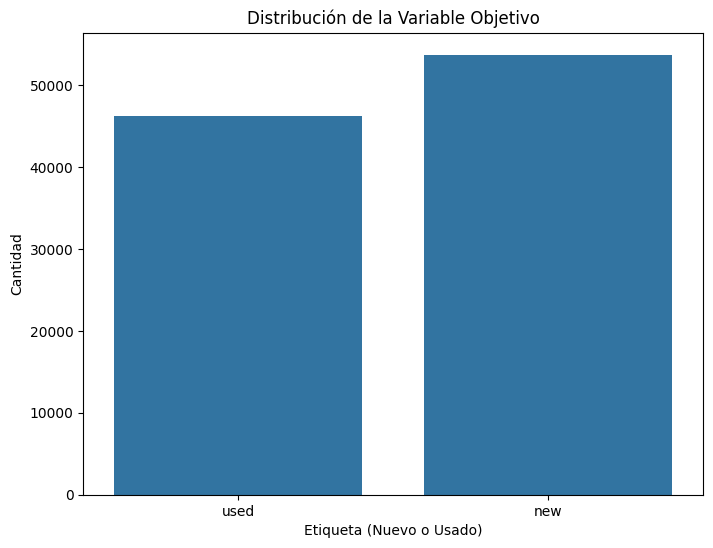

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df_EDA, x='label')
plt.title('Distribución de la Variable Objetivo')
plt.xlabel('Etiqueta (Nuevo o Usado)')
plt.ylabel('Cantidad')
plt.show()

Se puede evidenciar que la proporción entre artículos nuevos o usados no es muy distinta, lo cuál nos ahorra el uso de técnicas de balanceo que requerirían un procesamiento adicional.

## variables numéricas vs variable objetivo

### conteo y resolución de las imágenes

sobre el conteo de imágenes en los artículos:

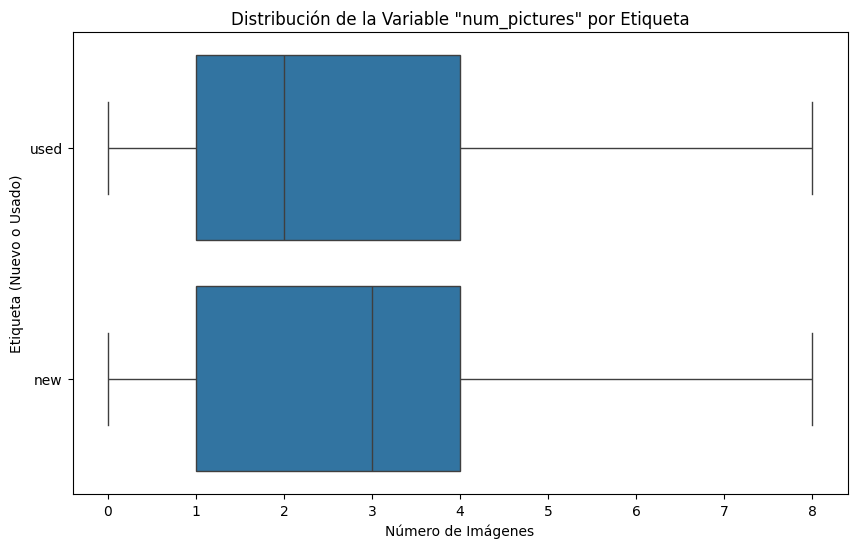

In [54]:
# Crear un boxplot horizontal para la variable 'num_pictures' dividida por la variable 'label'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_EDA, x='num_pictures', y='label', orient='h', showfliers=False)
plt.title('Distribución de la Variable "num_pictures" por Etiqueta')
plt.xlabel('Número de Imágenes')
plt.ylabel('Etiqueta (Nuevo o Usado)')
plt.show()

Basados en la ubicación de la mediana, observamos que los artículos nuevos tienden a tener una mayor cantidad de imágenes en comparación con los artículos usados.

sobre la resolución de las imágenes:

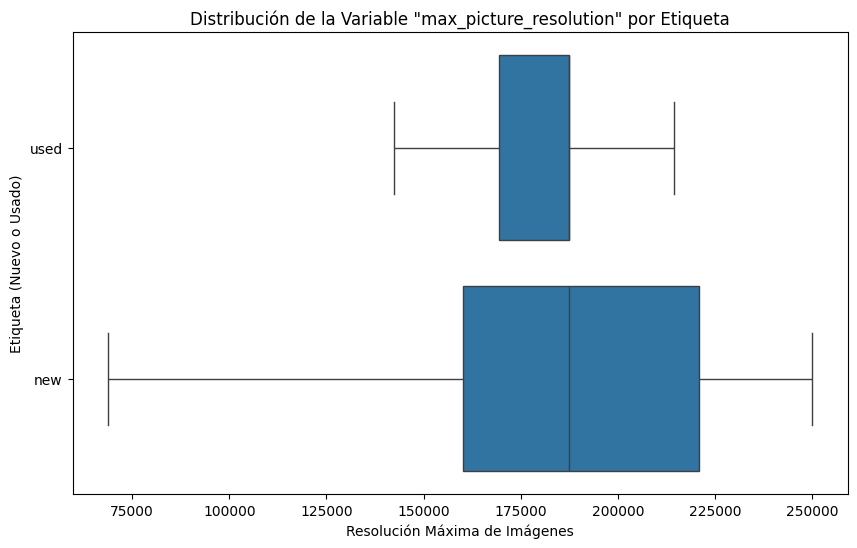

In [69]:
# Crear un boxplot horizontal para la variable 'max_picture_resolution' dividida por la variable 'label'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_EDA, x='max_picture_resolution', y='label', orient='h', showfliers=False)
plt.title('Distribución de la Variable "max_picture_resolution" por Etiqueta')
plt.xlabel('Resolución Máxima de Imágenes')
plt.ylabel('Etiqueta (Nuevo o Usado)')
plt.show()

Se puede observar que la varianza para la resolución de las imágenes de artículos usados es menor, dado que hay más concentración de datos. Sin embargo se puede decir que almenos la mitad de las fotos de los artículos nuevos tienen igual o mejor calidad que las fotos de los artículos usados. Esto puede ir alineado con los esfuerzos de sellers más grandes que hacen mayores esfuerzos en la venta de sus productos nuevos.

### unidades del artículo

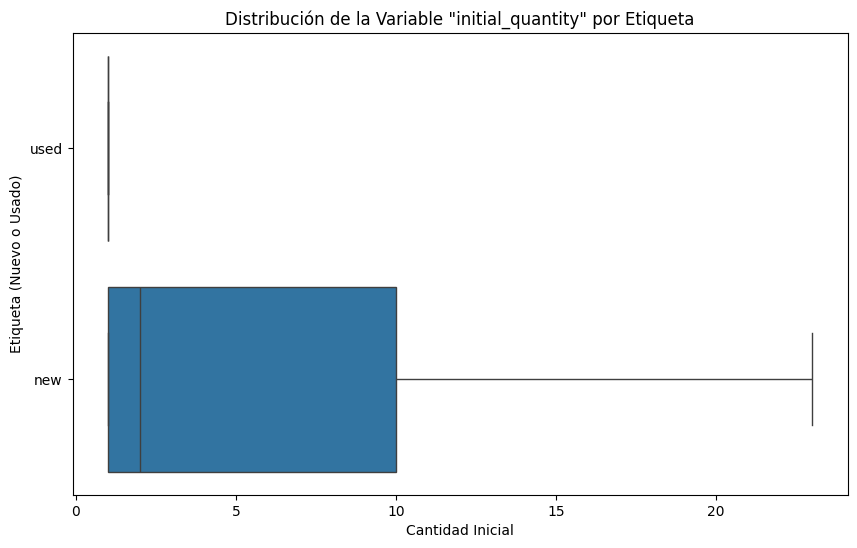

In [60]:
# Crear un boxplot horizontal para la variable 'initial_quantity' dividida por la variable 'label'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_EDA, x='initial_quantity', y='label', orient='h', showfliers=False)
plt.title('Distribución de la Variable "initial_quantity" por Etiqueta')
plt.xlabel('Cantidad Inicial')
plt.ylabel('Etiqueta (Nuevo o Usado)')
plt.show()

este gráfico muestra un insight muy bueno. En su mayoría, los artículos usados se publican con 1 unidad disponible, mientras que los artículos nuevos tienen una mediana de 2 aproximadamente y una distribución del Q3 entre 2 y 10 unidades.

Esto es un indicio de que en general, si un ítem es nuevo, tendrá más de una unidad disponible, pero si es usado, típicamente se publica una unidad.

### precio del artículo

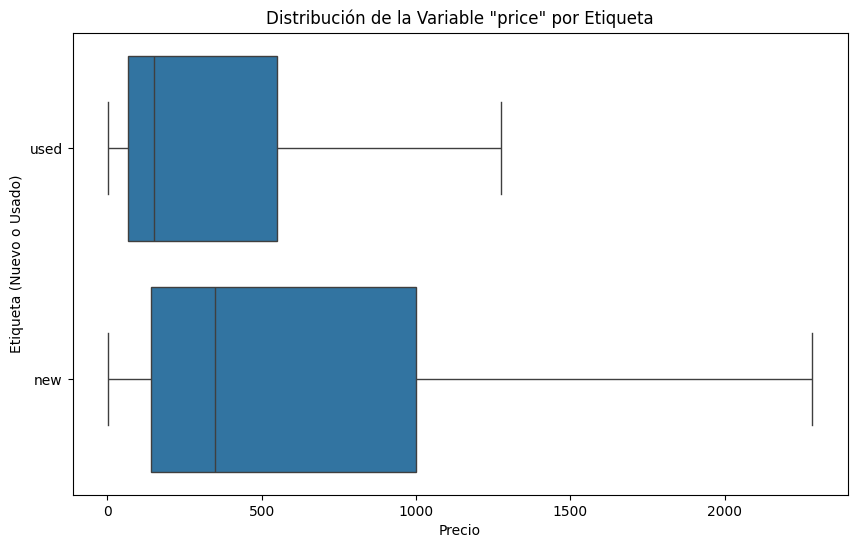

In [62]:
# Crear un boxplot horizontal para la variable 'price' dividida por la variable 'label'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_EDA, x='price', y='label', orient='h', showfliers = False)
plt.title('Distribución de la Variable "price" por Etiqueta')
plt.xlabel('Precio')
plt.ylabel('Etiqueta (Nuevo o Usado)')
plt.show()

se evidencia que los artículos nuevos tienen en general, un costo mayor que los usados. Lo cuál es intuitivo dado que las cosas usadas se deprecian.

## variables categóricas vs la variable objetivo

### tipo de listado

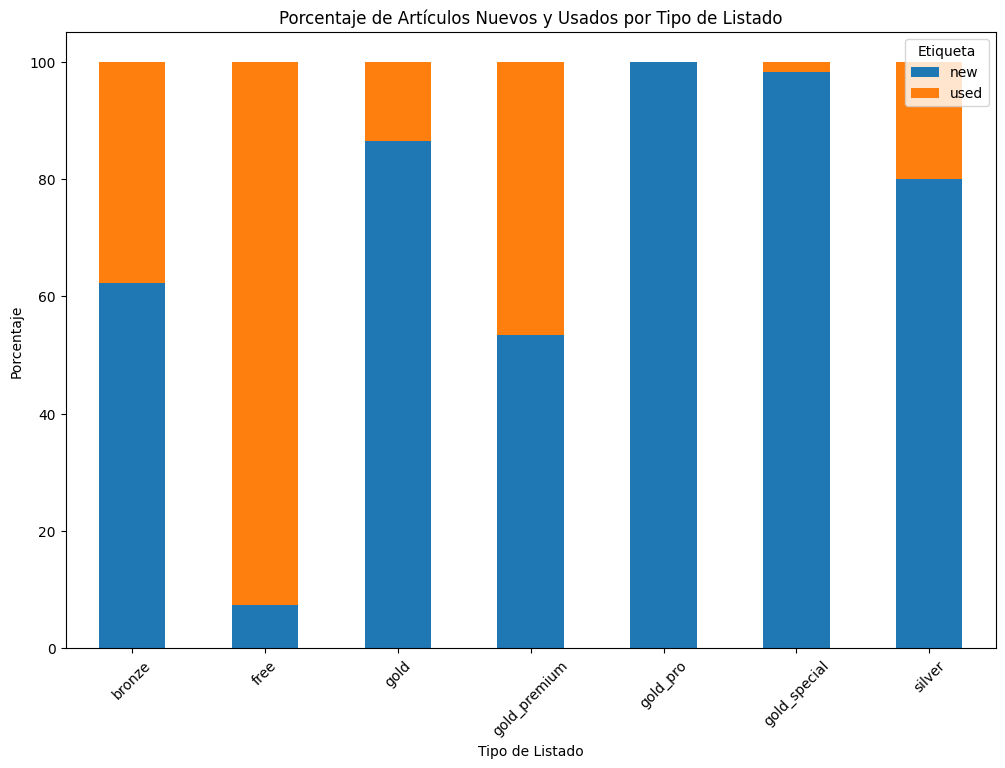

In [67]:
# Calcular el porcentaje de artículos nuevos y usados para cada valor de 'listing_type_id'
listing_type_distribution = df_EDA.groupby(['listing_type_id', 'label']).size().unstack(fill_value=0)
listing_type_percentage = listing_type_distribution.div(listing_type_distribution.sum(axis=1), axis=0) * 100

# Crear un diagrama de barras apilado para los porcentajes de artículos nuevos y usados por 'listing_type_id'
listing_type_percentage.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Porcentaje de Artículos Nuevos y Usados por Tipo de Listado')
plt.xlabel('Tipo de Listado')
plt.ylabel('Porcentaje')
plt.legend(title='Etiqueta')
plt.xticks(rotation=45)
plt.show()

este gráfico de barras apilado nos muestra información muy valiosa asociada a la variable `listing_type_id`, podemos evidenciar:

- para el `listing_type_id` de tipo `free` hay mayor porcentaje de artículos usados.

- para los `listing_type_id` de tipo `bronze`, `silver` y `gold` hay un porcentaje mayor de artículos nuevos. 

Esto puede ser una variable predictora muy fuerte para indicar si el artículo es nuevo o usado.

### acepta mercadopago

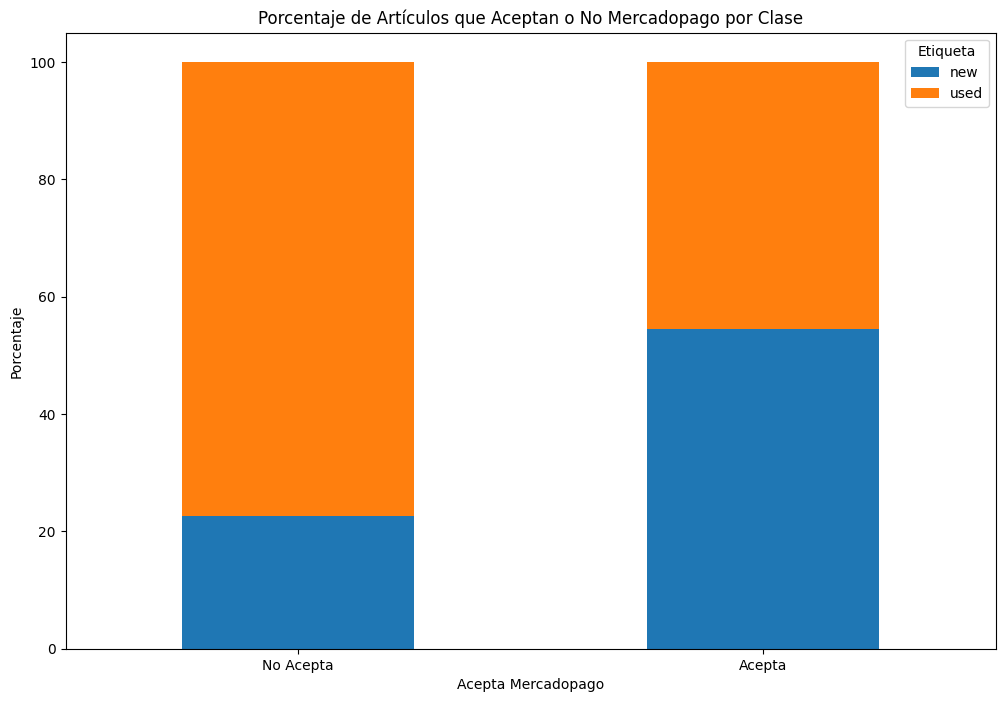

In [70]:
# Calcular el porcentaje de artículos que aceptan o no Mercadopago para cada clase en la variable objetivo
mercadopago_distribution = df_EDA.groupby(['accepts_mercadopago', 'label']).size().unstack(fill_value=0)
mercadopago_percentage = mercadopago_distribution.div(mercadopago_distribution.sum(axis=1), axis=0) * 100

# Crear un diagrama de barras apilado para los porcentajes de artículos que aceptan o no Mercadopago por clase en la variable objetivo
fig, ax = plt.subplots(figsize=(12, 8))

mercadopago_percentage.plot(kind='bar', stacked=True, ax=ax)

ax.set_title('Porcentaje de Artículos que Aceptan o No Mercadopago por Clase')
ax.set_xlabel('Acepta Mercadopago')
ax.set_ylabel('Porcentaje')
ax.legend(title='Etiqueta', loc='upper right')
ax.set_xticklabels(['No Acepta', 'Acepta'], rotation=0)

plt.show()

la proporción de artículos usados que aceptan mercadopago es bastante menor a comparación de la proporción de artículos nuevos que aceptan este medio de pago.

En otras palabras, los artículos usados no suelen aceptar mercado pago, mientras que este medio de pago es más común en los artículos nuevos.

# Entrenamiento del modelo

a pesar de toda la manipulación de datos hecha anteriormente, en este apartado se vuelve a las particiones de `test` y `train` originalmente suministradas para la prueba.

## Preprocesamiento

primero, se convierte el label en números. Consideremos que `used` es la clase positiva en este caso.

In [46]:
y_train = [0 if condition == 'new' else 1 for condition in y_train]
y_test = [0 if condition == 'new' else 1 for condition in y_test]

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

ahora se tratan todas las columnas categóricas de `X_train` y `X_test` que aun no han sido procesadas.

In [47]:
# volviendo a la notacion tipica de sklearn
X_train = df_X_train.copy()
X_test = df_X_test.copy()

In [48]:
# Identificar las columnas categóricas
categorical_columns = ['listing_type_id', 'buying_mode', 'status', 'seller_address_state', 'extracted_sub_status', 'shipping_field_mode']

# Aplicar one-hot encoding
X_train = pd.get_dummies(X_train, columns=categorical_columns)

# Guardar las columnas resultantes
dummy_columns = X_train.columns

# convertir las columnas booleanas a int
bool_columns = X_train.select_dtypes(include='bool').columns
X_train[bool_columns] = X_train[bool_columns].astype(int)

# Mostrar las primeras filas del DataFrame transformado
X_train.head()

,price,accepts_mercadopago,automatic_relist,initial_quantity,sold_quantity,available_quantity,num_pictures,unique_picture_resolutions,avg_picture_resolution,max_picture_resolution,...,seller_address_state_Tierra del Fuego,seller_address_state_Tucumán,extracted_sub_status_deleted,extracted_sub_status_expired,extracted_sub_status_non_specified,extracted_sub_status_suspended,shipping_field_mode_custom,shipping_field_mode_me1,shipping_field_mode_me2,shipping_field_mode_not_specified
0,80.0,1,0,1,0,1,2,1,187500.000000,187500,...,0,0,0,0,1,0,0,0,0,1
1,2650.0,1,0,1,0,1,6,3,179944.333333,187500,...,0,0,0,0,1,0,0,0,1,0
2,60.0,1,0,1,0,1,1,1,187500.000000,187500,...,0,0,0,0,1,0,0,0,1,0
3,580.0,1,0,1,0,1,2,2,186271.500000,186543,...,0,0,0,0,1,0,0,0,1,0
4,30.0,1,0,1,0,1,2,1,187500.000000,187500,...,0,0,0,0,1,0,0,0,0,1


In [49]:
# Aplicar one-hot encoding
X_test = pd.get_dummies(X_test, columns=categorical_columns)

# Asegurar que df_X_test_encoded tenga las mismas columnas que df_X_train_encoded
X_test = X_test.reindex(columns=dummy_columns, fill_value=0)

# convertir las columnas booleanas a int
bool_columns = X_test.select_dtypes(include='bool').columns
X_test[bool_columns] = X_test[bool_columns].astype(int)

# Mostrar las primeras filas del DataFrame transformado
X_test.head()

,price,accepts_mercadopago,automatic_relist,initial_quantity,sold_quantity,available_quantity,num_pictures,unique_picture_resolutions,avg_picture_resolution,max_picture_resolution,...,seller_address_state_Tierra del Fuego,seller_address_state_Tucumán,extracted_sub_status_deleted,extracted_sub_status_expired,extracted_sub_status_non_specified,extracted_sub_status_suspended,shipping_field_mode_custom,shipping_field_mode_me1,shipping_field_mode_me2,shipping_field_mode_not_specified
0,6700.0,1,0,1,0,1,6,3,195416.666667,232000,...,0,0,0,0,1,0,1,0,0,0
1,119.0,1,0,19,0,19,3,1,187500.000000,187500,...,0,0,0,0,1,0,0,0,0,1
2,450.0,1,0,2,0,2,3,3,103245.000000,175136,...,0,0,0,0,1,0,0,0,1,0
3,40.0,1,0,1,0,1,2,1,187500.000000,187500,...,0,0,0,0,1,0,0,0,1,0
4,30.0,1,0,1,1,1,1,1,198000.000000,198000,...,0,0,0,0,1,0,0,0,0,1


se verifica una ultima vez que no hayan valores nulos ni en la particion de train ni de test

In [50]:
def check_null_values(df):
    # Calcular el porcentaje de valores nulos para cada columna
    null_percentage = df.isnull().mean() * 100
    
    # Filtrar solo las columnas que tienen valores nulos
    columns_with_nulls = null_percentage[null_percentage > 0].sort_values(ascending=False)
    
    if not columns_with_nulls.empty:
        print("Hay columnas con valores nulos.")
        nulls_df = columns_with_nulls.reset_index()
        nulls_df.columns = ['Column', 'Null_Percentage']
        return nulls_df
    else:
        print("No hay columnas con valores nulos.")
        return pd.DataFrame(columns=['Column', 'Null_Percentage'])

nulls_df = check_null_values(X_train)
print(nulls_df)

print('')
print('')

nulls_df = check_null_values(X_test)
print(nulls_df)

No hay columnas con valores nulos.
Empty DataFrame
Columns: [Column, Null_Percentage]
Index: []


No hay columnas con valores nulos.
Empty DataFrame
Columns: [Column, Null_Percentage]
Index: []


## Pipeline de entrenamiento

ahora se ejecuta el `pipeline` de entrenamiento del modelo, este pipeline está diseñado para hacer `búsqueda aleatoria de hiperparámetros` y guardar el mejor modelo en un archivo local, el cuál puede ser posteriormente recuperado para calcular métricas, hacer predicciones, etc.

Adicionalmente, el pipeline recibe otros posibles modelos para hacer experimentos, en esta ocasión solo se hace uso de `XGBoost`.

C:\Users\Martin\AppData\Local\Temp\ipykernel_5776\476999942.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(results[::-1], labels=labels[::-1], vert=False)


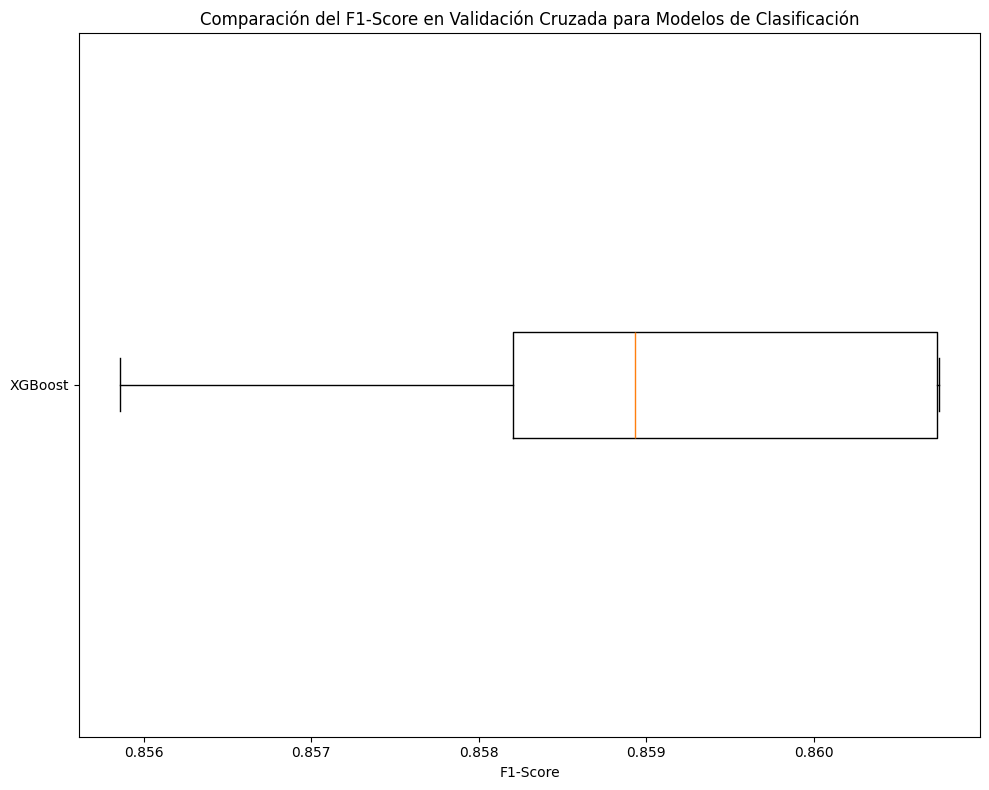

In [52]:
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
# from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import joblib

# Definir los hiperparámetros para los modelos
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

model_params = {
    # "Regresión Logística": (LogisticRegression(), {
    #     'classifier__C': [0.01, 0.1, 1, 10],
    #     'classifier__penalty': ['l1', 'l2'],
    #     'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    #     'classifier__max_iter': [100, 500, 1000],
    #     'classifier__class_weight': [None, 'balanced'],
    #     'classifier__fit_intercept': [True, False]
    # }),
    "XGBoost": (xgb.XGBClassifier(), {
        'classifier__learning_rate': [0.001, 0.01, 0.1],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.7, 0.8, 0.9],
        'classifier__gamma': [0.1, 0.2],
        'classifier__lambda': [0.1, 1.0],
        'classifier__alpha': [0.1, 1.0],
        'classifier__scale_pos_weight': [3, 4, 5, scale_pos_weight],
        'classifier__max_delta_step': [1, 2, 5, 10]
    })
}

def train_model(X_train, y_train, classifier, params, scoring, model_name):
    if "random_state" in classifier.get_params().keys():
        classifier.set_params(random_state=42)

    pipeline = Pipeline([
        # ("imputation", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("classifier", classifier)
    ])

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    model = RandomizedSearchCV(pipeline, param_distributions=params, n_iter=50, cv=kf, scoring=scoring, n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)
    filename = f"{model_name}.pkl"
    joblib.dump(model, filename)
    return model

results = []
labels = []

for name, (classifier, params) in model_params.items():

    model = train_model(X_train=X_train, y_train=y_train, classifier=classifier, params=params, scoring='f1', model_name=name)
    best_model = model.best_estimator_
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=KFold(n_splits=5, random_state=42, shuffle=True), scoring='f1')
    results.append(cv_scores)
    labels.append(name)

# Crear el gráfico de box plot
fig, ax = plt.subplots(figsize=(10, 8))  # Ajustar el tamaño de la figura
ax.boxplot(results[::-1], labels=labels[::-1], vert=False) 
ax.set_xlabel('F1-Score')
ax.set_title('Comparación del F1-Score en Validación Cruzada para Modelos de Clasificación')

# Ajustar el diseño para evitar recortes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

el gráfico que genera es la distribución de los valores para el `f1-score` en `validación cruzada` para cada uno de los `folds`, en este caso se utilizaron 5 pliegues o `folds`

## Calculando métricas de clasificación

### Curva roc (AUC)

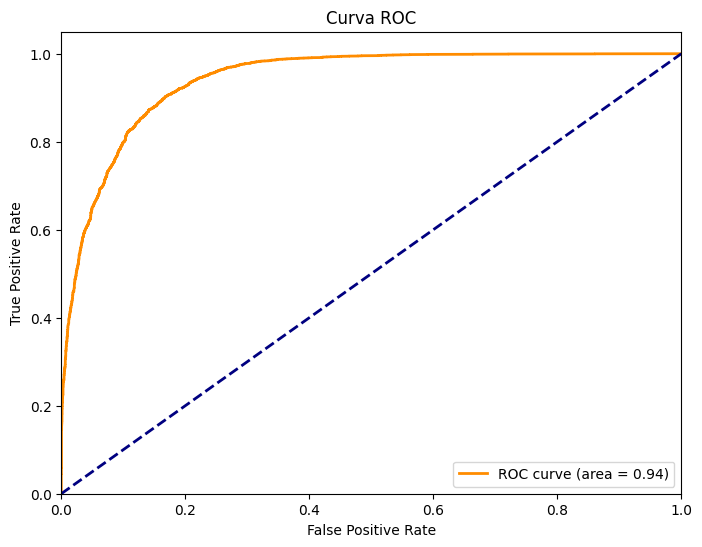

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import joblib
from sklearn.model_selection import train_test_split

# Cargar el modelo XGBoost sin SMOTE
model_xgboost = joblib.load("XGBoost.pkl")
best_model_xgboost = model_xgboost.best_estimator_

# Predecir las probabilidades para la clase positiva
y_pred_prob = best_model_xgboost.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")

plt.show()

El valor obtenido para el `AUC` es 0.94

:)

### Accuracy, Recall, Precision, F1

In [57]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Nombres de los modelos
model_names = [
    "XGBoost",
]

# Inicializar listas para almacenar los resultados
results = []

# Definir función para calcular métricas
def calculate_metrics(y_test, y_pred, y_pred_proba=None):
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred),
    }
    if y_pred_proba is not None:
        metrics["roc_auc"] = roc_auc_score(y_test, y_pred_proba)
    else:
        metrics["roc_auc"] = None
    return metrics

# Cargar y evaluar cada modelo
for name in model_names:
    # Evaluar el modelo sin SMOTE
    model = joblib.load(f"{name}.pkl")
    best_model = model.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None
    metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
    metrics["model"] = name
    results.append(metrics)

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

# Mostrar el DataFrame
results_df

,accuracy,recall,precision,f1_score,roc_auc,model
0,0.8637,0.905311,0.817574,0.859209,0.940957,XGBoost


Se obtiene un valor de `f1-score` para la partición de test de `0.86`, muy similar a los valores obtenidos para el f1-score de validación cruzada durante el entrenamiento. Lo cuál indica que no hay sobreajuste del modelo.

Adicionalmente, un `AUC` de `0.94`, el cuál es muy positivo considerando el requerimiento de`0.86` mencionado en el enunciado de la prueba.

## feature importance

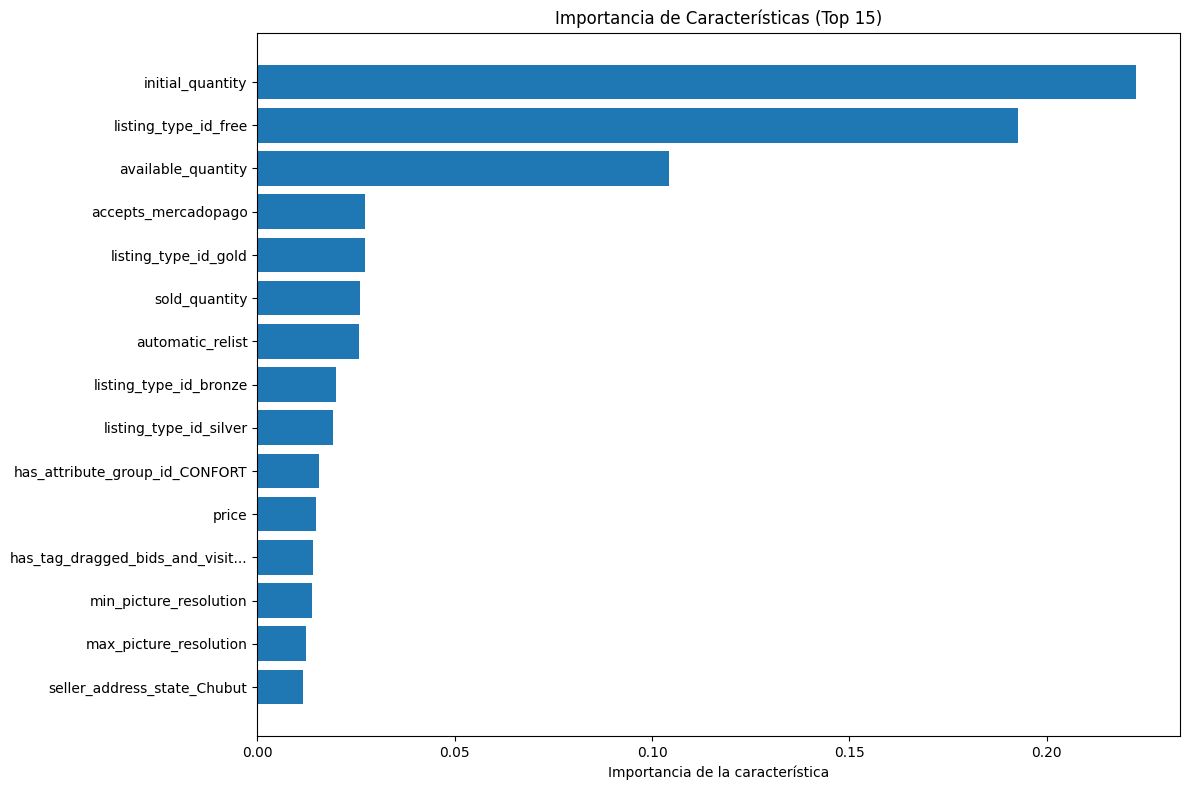

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Cargar el modelo XGBoost sin SMOTE
model_xgboost = joblib.load("XGBoost.pkl")
best_model_xgboost = model_xgboost.best_estimator_

# Suponiendo que X_train está definido con tus datos de entrenamiento
# Extraer el modelo entrenado de XGBoost
xgboost_model = best_model_xgboost.named_steps['classifier']

# Obtener la importancia de las características
importances = xgboost_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Seleccionar el top 15 características más importantes
top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_features = X_train.columns[top_indices]

# Abreviar los nombres de las características si es necesario
abbreviated_features = [feature[:30] + '...' if len(feature) > 30 else feature for feature in top_features]

# Plotear la importancia de características (horizontal)
plt.figure(figsize=(12, 8))  # Aumentar el ancho de la figura
plt.title("Importancia de Características (Top 15)")
plt.barh(range(top_n), top_importances, align="center")
plt.yticks(range(top_n), abbreviated_features, fontsize=10)  # Reducir el tamaño de la fuente
plt.xlabel('Importancia de la característica')
plt.gca().invert_yaxis()
plt.tight_layout()

# Guardar el gráfico de importancia de características en un archivo PNG
plt.savefig('feature_importance_xgboost.png', bbox_inches='tight')

plt.show()

el gráfico de feature importance confirma la utilidad de variables predictoras que fueron exploradas en el EDA, tales como `initial_quantity`, lo que nos dice que es clave saber la cantidad inicial de artículos disponibles para predecir si este es nuevo o usado. Seguido de variables como el `listing_type_id`, `accepts_mercadopago` o inclusive la variable `sold_quantity`.

En resumen, todas las variables visualizadas en este gráfico de importancia de variables, pertenecen al top 15 de mejores variables al momento de predecir este fenómeno.

In [59]:
top_features

Index(['initial_quantity', 'listing_type_id_free', 'available_quantity',
       'accepts_mercadopago', 'listing_type_id_gold', 'sold_quantity',
       'automatic_relist', 'listing_type_id_bronze', 'listing_type_id_silver',
       'has_attribute_group_id_CONFORT', 'price',
       'has_tag_dragged_bids_and_visits', 'min_picture_resolution',
       'max_picture_resolution', 'seller_address_state_Chubut'],
      dtype='object')

Y así concluye el ejercicio, muchas gracias y nos vemos dentro de MeLi :)